In [163]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from joblib import dump
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams["font.family"] = "MS Gothic"  # Windows用
matplotlib.rcParams["axes.unicode_minus"] = False


In [164]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1,2), min_df=2)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

model = LinearSVC(C=1.0)
model.fit(X_train_vec, y_train)

# 予測
y_pred = model.predict(X_test_vec)


In [165]:
BASE_DIR = Path().resolve()
DATA_DIR = BASE_DIR / "data"
MODELS_DIR = BASE_DIR / "models"
REPORTS_DIR = BASE_DIR / "reports"
DATA_DIR.mkdir(exist_ok=True)
MODELS_DIR.mkdir(exist_ok=True)
REPORTS_DIR.mkdir(exist_ok=True)

c:\Users\yt123\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\yt123\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\yt123\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

              precision    recall  f1-score   support

         その他      0.739     1.000     0.850       136
       哲学・宗教      0.000     0.000     0.000         3
       地理・紀行      0.000     0.000     0.000         5
          教育      0.000     0.000     0.000         9
          文学      0.000     0.000     0.000         4
          歴史      0.000     0.000     0.000         7
       理工・IT      0.000     0.000     0.000        15
     経済・ビジネス      0.000     0.000     0.000         5

    accuracy                          0.739       184
   macro avg      0.092     0.125     0.106       184
weighted avg      0.546     0.739     0.628       184



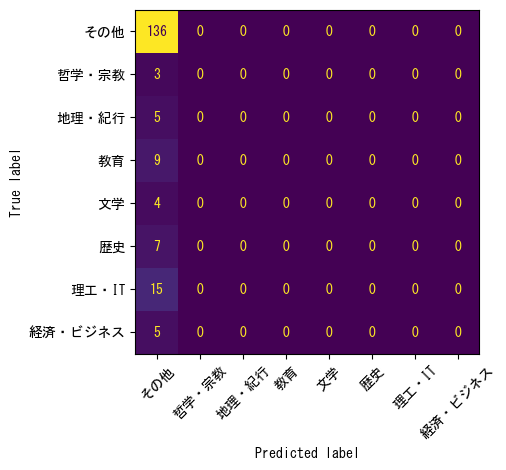

In [166]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print(classification_report(y_test, y_pred, digits=3))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, xticks_rotation=45, colorbar=False)
plt.tight_layout()
plt.show()

In [167]:
import pandas as pd
df = pd.read_csv("books_ja_real_1000.csv", encoding="utf-8-sig")
cols = list(map(str, df.columns))
title_col = "title" if "title" in cols else ("タイトル" if "タイトル" in cols else None)
if title_col is None: raise ValueError("タイトル列が見つかりません")
if "description" in cols:
    desc_series = df["description"].astype(str)
else:
    cand = [c for c in ["著者","出版者","シリーズタイトル","版表示","容量・大きさ"] if c in cols]
    desc_series = df[cand].astype(str).agg(" ".join, axis=1) if cand else df[title_col].astype(str)
genre_col = "genre" if "genre" in cols else ("ジャンル" if "ジャンル" in cols else None)
out = pd.DataFrame({
    "title": df[title_col].astype(str).str.strip(),
    "description": desc_series.str.replace(r"\s+"," ", regex=True).str.strip()
})
if genre_col:
    out["genre"] = df[genre_col].astype(str).str.strip()
else:
    def infer_genre(t):
        t = str(t)
        if any(k in t for k in ["歴史","戦国","幕末","城"]): return "歴史"
        if any(k in t for k in ["数学","物理","科学","工学","IT","プログラミング"]): return "理工・IT"
        if any(k in t for k in ["経済","ビジネス","会社","経営"]): return "経済・ビジネス"
        if any(k in t for k in ["教育","教師","学校"]): return "教育"
        if any(k in t for k in ["文学","小説","詩","作家"]): return "文学"
        return "その他"
    out["genre"] = out["title"].apply(infer_genre)
df = out


In [168]:
df = df.fillna({"title":"", "description":"", "genre":""})
X = (df["title"].astype(str) + "。 " + df["description"].astype(str)).str.strip()
y = df["genre"].astype(str).str.strip()
counts = y.value_counts()
y = y.where(~y.isin(counts[counts < 3].index), "その他")
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
len(X_train), len(X_test)

(734, 184)

In [169]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2), min_df=2)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)
model = LinearSVC()
model.fit(X_train_vec, y_train)
model

,penalty,'l2'
,loss,'squared_hinge'
,dual,'auto'
,tol,0.0001
,C,1.0
,multi_class,'ovr'
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,verbose,0
,random_state,None


In [170]:
import pandas as pd
cols = list(map(str, df.columns))
def pick(cols, candidates):
    for cand in candidates:
        hits = [c for c in cols if cand in c]
        if hits:
            return hits[0]
    return None
title_col = pick(cols, ["タイトル", "title"])
if title_col is None:
    raise ValueError("タイトル列が見つかりません")
desc_candidates = ["著者","出版者","シリーズタイトル","版表示","容量","大きさ","公開","権利","識別子","件名","注記","備考","概要"]
desc_cols = [c for c in cols if any(k in c for k in desc_candidates)]
titles = df[title_col].astype(str).str.strip()
if desc_cols:
    desc_series = df[desc_cols].astype(str).agg(" / ".join, axis=1).str.replace(r"\s+"," ",regex=True).str.strip()
else:
    desc_series = pd.Series([""]*len(df))
import re
def tag_genre(t,d):
    s = f"{t} {d}"
    if re.search(r"(物理|数学|化学|生物|工学|機械|電気|電子|計算機|情報|統計|AI|人工知能|プログラム|コンピュータ)",s): return "理工・IT"
    if re.search(r"(相撲|柔術|武道|剣道|弓道|兵法|柔道|合気|空手|体育|スポーツ)",s): return "スポーツ・武道"
    if re.search(r"(歴史|史話|戦史|明治|大正|昭和|戦国|幕末|古代|中世|近世|郷土)",s): return "歴史"
    if re.search(r"(文学|小説|詩|随筆|俳句|歌|歌集|短歌|童話|戯曲)",s): return "文学"
    if re.search(r"(教育|教科|授業|学級|学校|学習|読本|教科書|指導)",s): return "教育"
    if re.search(r"(哲学|思想|倫理|宗教|信仰|仏教|神道|儒教|道徳)",s): return "哲学・宗教"
    if re.search(r"(地理|旅行|紀行|地誌|名所|案内|図説|図解)",s): return "地理・紀行"
    if re.search(r"(経済|経営|商業|簿記|工場|産業|統制|金融|銀行|商法)",s): return "経済・ビジネス"
    return "その他"
genre = [tag_genre(t,d) for t,d in zip(titles,desc_series)]
out = pd.DataFrame({"title":titles,"description":desc_series,"genre":genre})
out = out[out["title"] != ""].drop_duplicates().reset_index(drop=True)
display(out.head())


,title,description,genre
0,三国町概観,,その他
1,セザンヌゴオホ画集,,その他
2,北海道薬用植物図彙,,その他
3,英国の船舶管理・戦後英国海運政策・上半期英国売船市場・英米両国の海運競争,,その他
4,"淡水魚類養殖販売法 : 鯉,金魚,鮎,鰻,鰡,鼈等",,その他


In [171]:
# --- データを1000件にサンプリングして保存 ---
target = 1000

if len(out) >= target:
    out_sampled = out.sample(target, random_state=42).reset_index(drop=True)
else:
    out_sampled = out.reset_index(drop=True)

# CSVファイルとして保存（次の学習用）
out_sampled.to_csv("books_ja_real_1000.csv", index=False, encoding="utf-8-sig")

# 上位5件を確認
out_sampled.head()


,title,description,genre
0,三国町概観,,その他
1,セザンヌゴオホ画集,,その他
2,北海道薬用植物図彙,,その他
3,英国の船舶管理・戦後英国海運政策・上半期英国売船市場・英米両国の海運競争,,その他
4,"淡水魚類養殖販売法 : 鯉,金魚,鮎,鰻,鰡,鼈等",,その他


In [172]:
import pandas as pd
from sklearn.model_selection import train_test_split
df = pd.read_csv("books_ja_real_1000.csv", encoding="utf-8-sig")
X = (df["title"].astype(str) + " " + df["description"].astype(str)).str.strip()
y = df["genre"].astype(str).str.strip()
counts = y.value_counts()
y = y.where(~y.isin(counts[counts < 3].index), "その他")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
len(X_train), len(X_test)

(734, 184)

In [173]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1,2), min_df=2, sublinear_tf=True)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)
model = LinearSVC(C=1.0)
model.fit(X_train_vec, y_train)
y_pred = model.predict(X_test_vec)

              precision    recall  f1-score   support

         その他      0.739     1.000     0.850       136
       哲学・宗教      0.000     0.000     0.000         3
       地理・紀行      0.000     0.000     0.000         5
          教育      0.000     0.000     0.000         9
          文学      0.000     0.000     0.000         4
          歴史      0.000     0.000     0.000         7
       理工・IT      0.000     0.000     0.000        15
     経済・ビジネス      0.000     0.000     0.000         5

    accuracy                          0.739       184
   macro avg      0.092     0.125     0.106       184
weighted avg      0.546     0.739     0.628       184



c:\Users\yt123\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\yt123\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\yt123\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

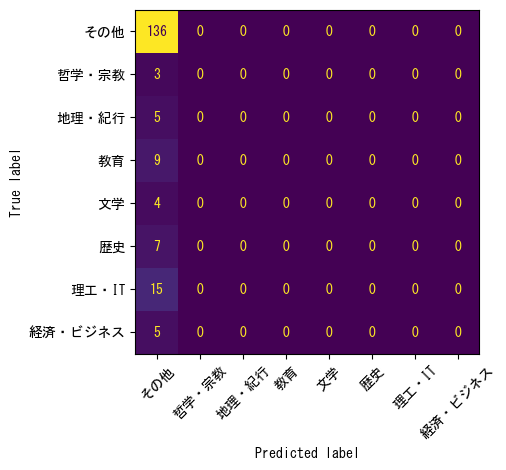

In [174]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
print(classification_report(y_test, y_pred, digits=3))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, xticks_rotation=45, colorbar=False)
plt.tight_layout()
plt.show()

In [175]:
from sklearn.pipeline import Pipeline
from joblib import dump
from pathlib import Path
pipe = Pipeline([("tfidf", TfidfVectorizer(max_features=20000, ngram_range=(1,2), min_df=2, sublinear_tf=True)),
                 ("svc", LinearSVC(C=1.0))])
pipe.fit(X, y)
Path("models").mkdir(exist_ok=True)
dump(pipe, "models/genre_pipeline.joblib")
np.save("models/labels.npy", np.unique(y))
print("saved:", "models/genre_pipeline.joblib, models/labels.npy")
"saved"

saved: models/genre_pipeline.joblib, models/labels.npy


'saved'

In [176]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from joblib import dump
from pathlib import Path
import numpy as np

pipe = make_pipeline(
    TfidfVectorizer(
        analyzer="char",        # ← 単語ではなく「文字」単位に！
        ngram_range=(2, 5),     # 2〜5文字の連続を特徴として学習
        min_df=1,
        max_features=80000,
        sublinear_tf=True,
        lowercase=False
    ),
    LinearSVC(C=1.0, class_weight="balanced")
)

pipe.fit(X_train, y_train)

Path("models").mkdir(exist_ok=True)
dump(pipe, "models/genre_pipeline.joblib")
np.save("models/labels.npy", np.unique(y_train))

print("✅ saved:", "models/genre_pipeline.joblib, models/labels.npy")


✅ saved: models/genre_pipeline.joblib, models/labels.npy


In [177]:
from joblib import load
from pathlib import Path
import os, time, numpy as np

m = Path("models/genre_pipeline.joblib")
l = Path("models/labels.npy")
print("model exists:", m.exists(), "mtime:", time.ctime(m.stat().st_mtime) if m.exists() else None)
print("labels exists:", l.exists(), "mtime:", time.ctime(l.stat().st_mtime) if l.exists() else None)

pipe = load(m)
# make_pipeline なら自動名 'tfidfvectorizer'、手動で ('tfidf', ...) なら 'tfidf'
vec = getattr(pipe, "named_steps", {}).get("tfidfvectorizer") or getattr(pipe, "named_steps", {}).get("tfidf")
print("analyzer:", getattr(vec, "analyzer", None), "ngram_range:", getattr(vec, "ngram_range", None), "max_features:", getattr(vec, "max_features", None))


model exists: True mtime: Fri Oct 17 16:11:11 2025
labels exists: True mtime: Fri Oct 17 16:11:11 2025
analyzer: char ngram_range: (2, 5) max_features: 80000


In [178]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("books_ja_real_1000.csv", encoding="utf-8-sig")

# 入力文を作成（タイトル＋説明）
X = (df["title"].astype(str) + " " + df["description"].astype(str)).str.strip()
y = df["genre"].astype(str).str.strip()

# 出現数が少ないジャンルを「その他」にまとめる
counts = y.value_counts()
y = y.where(~y.isin(counts[counts < 3].index), "その他")

# データ分割（学習80% / テスト20%）
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

len(X_train), len(X_test)


(734, 184)

In [179]:
print(out["genre"].value_counts())

genre
その他        676
理工・IT       74
教育          46
歴史          36
経済・ビジネス     26
地理・紀行       22
文学          22
哲学・宗教       15
スポーツ・武道      1
Name: count, dtype: int64


              precision    recall  f1-score   support

         その他      0.739     1.000     0.850       136
       哲学・宗教      0.000     0.000     0.000         3
       地理・紀行      0.000     0.000     0.000         5
          教育      0.000     0.000     0.000         9
          文学      0.000     0.000     0.000         4
          歴史      0.000     0.000     0.000         7
       理工・IT      0.000     0.000     0.000        15
     経済・ビジネス      0.000     0.000     0.000         5

    accuracy                          0.739       184
   macro avg      0.092     0.125     0.106       184
weighted avg      0.546     0.739     0.628       184



c:\Users\yt123\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\yt123\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\yt123\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

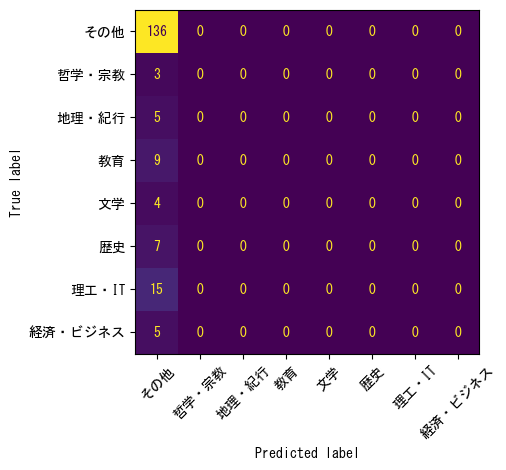

In [180]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1,2), min_df=2)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)
model = LinearSVC(C=1.0)
model.fit(X_train_vec, y_train)
y_pred = model.predict(X_test_vec)
print(classification_report(y_test, y_pred, digits=3))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, xticks_rotation=45, colorbar=False)
plt.tight_layout()
plt.show()